<div style="background-color:white;" >
<div style="clear: both; display: table;">
  <div style="float: left; width: 14%; padding: 5px; height:auto">
    <img src="img/TUBraunschweig_CO_200vH_300dpi.jpg" alt="TU_Braunschweig" style="width:100%">
  </div>
  <div style="float: left; width: 28%; padding: 5px; height:auto">
    <img src="img/TU_Clausthal_Logo.png" alt="TU_Clausthal" style="width:100%">
  </div>
  <div style="float: left; width: 25%; padding: 5px; height:auto">
    <img src="img/ostfalia.jpg" alt="Ostfalia" style="width:100%">
  </div>
  <div style="float: left; width: 21%; padding: 5px;">
    <img src="img/niedersachsen_rgb_whitebg.png" alt="Niedersachsen" style="width:100%">
  </div>
  <div style="float: left; width: 9%; padding: 5px;">
    <img src="img/internet_BMBF_gefoerdert_2017_en.jpg" alt="bmbf" style="width:100%">
  </div>
</div>
<div style="text-align:center">
<img src="img/ki4all.jpg" alt="KI4ALL-Logo" width="200"/>
</div>
</div>

# Synthetic Biomedical Data – Lesson 4: Non-Causal Variation
Part of the *Microcredit Artificial Data Generator* module.

➡️ [Back to Lesson 4a: Understanding Non-Causal Variation](04a_non_causal_variation_understanding.ipynb)
➡️ [Module README](../README.md)

*Before continuing, please ensure you reviewed the prerequisites and learning goals in Lesson 1.*


# Lesson 4b: Generating Non-Causal Variation

### Recap
In Lesson 4a, you learned:
- What non-causal variation is and why it matters
- Common sources: batch effects, site effects, instrument differences
- The difference between perfect and partial confounding
- Why standard random CV fails under confounding

Now it's time to get hands-on: you'll learn to **generate** synthetic datasets with controlled non-causal variation.

### Why this lesson: Generate to understand

The best way to understand confounding is to **create it yourself** with known ground truth:
- Control confounding strength from 0% (balanced) to 100% (perfect)
- Control technical effect sizes (weak vs. strong batch effects)
- Know exactly which features are artifacts vs. biology
- Visualize how confounding distorts feature space

This prepares you to:
- Design evaluation experiments (Lesson 4c)
- Benchmark method robustness (Lesson 4d)
- Recognize confounding patterns in real data

### What you'll learn
After completing this notebook, you will be able to:
- Use `BatchEffectsConfig` to add technical variation to synthetic data.
- Generate datasets with no confounding (balanced batches).
- Generate datasets with partial confounding (recruitment bias).
- Generate datasets with perfect confounding (complete separation).
- Control which features are affected by batch effects (all vs. informative only).
- Visualize batch and confounding structure in PCA and correlation matrices.
- Create multi-site datasets that mimic real multi-center studies.
- Adjust effect sizes to simulate realistic vs. extreme scenarios.

# Step 1: Setup and Imports

In [1]:
# If needed, install or upgrade the package (uncomment in managed environments)
# %pip install -U biomedical-data-generator

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from biomedical_data_generator import (
    generate_dataset,
    DatasetConfig,
    ClassConfig,
    BatchEffectsConfig
)
from utils import (
    plot_pca_by_class_and_batch_from_meta,
    summarize_batch_distribution_by_class,
    summarize_class_balance_per_batch,
)

# Set plotting style
from nb_setup import apply_style

apply_style()

# Create RNG for reproducibility
rng = np.random.default_rng(42)

# Step 2: Baseline Dataset (No Non-Causal Variation)

Let's start by generating a simple dataset **without** any batch effects. This gives us a baseline to compare against.

## Dataset design:
- 100 samples (50 healthy, 50 diseased)
- 10 informative features (true biology)
- 100 noise features (irrelevant)
- No batch effects → pure biological signal

In [3]:
# Baseline configuration without batch effects
def make_default_config(batch, random_state: int = 42):
    """Create a standard DatasetConfig where only the batch settings vary."""

    return DatasetConfig(
        n_informative=10,
        n_noise=100,
        class_configs=[
            ClassConfig(n_samples=50, label="healthy"),
            ClassConfig(n_samples=50, label="diseased"),
        ],
        class_sep=[1.5],
        batch_effects=batch,
        random_state=random_state,
    )


X_baseline, y_baseline, meta_baseline = generate_dataset(make_default_config(batch=None))

print("Baseline Dataset (No Batch Effects)")
print("=" * 50)
for class_id, n_class_samples in meta_baseline.samples_per_class.items():
    print(f"Class {class_id} - {meta_baseline.class_names[class_id]}:\t (n={n_class_samples})")
print(f"{len(meta_baseline.informative_idx)} informative features: {meta_baseline.informative_idx}")
print(f"{len(meta_baseline.noise_idx)} noise features: {meta_baseline.noise_idx[0]}...{meta_baseline.noise_idx[-1]}")

Baseline Dataset (No Batch Effects)
Class 0 - healthy:	 (n=50)
Class 1 - diseased:	 (n=50)
10 informative features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100 noise features: 10...109


## Visualize baseline: PCA

Let's see how the two classes separate in PCA space when there are **no artifacts**.

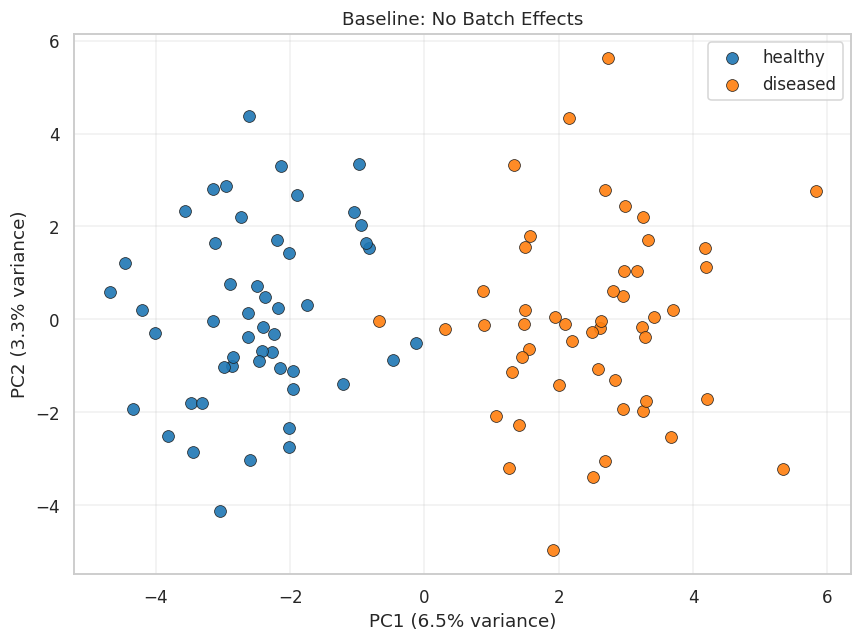


✓ Classes separate based on biology only
✓ No additional structure or clustering visible


In [4]:
from sklearn.decomposition import PCA

# PCA on baseline data
pca_baseline = PCA(n_components=2, random_state=42)
x_pca_baseline = pca_baseline.fit_transform(X_baseline)

colors_int = {0: "tab:blue", 1: "tab:orange"}
label_names = {0: "healthy", 1: "diseased"}

fig, ax = plt.subplots(figsize=(8, 6))
for cls, col in colors_int.items():
    mask = y_baseline == cls
    ax.scatter(
        x_pca_baseline[mask, 0],
        x_pca_baseline[mask, 1],
        label=label_names[cls],
        color=col,
        s=60,
        edgecolor="k",
        linewidth=0.5,
        alpha=0.9,
    )
ax.set_xlabel(f"PC1 ({pca_baseline.explained_variance_ratio_[0]:.1%} variance)")
ax.set_ylabel(f"PC2 ({pca_baseline.explained_variance_ratio_[1]:.1%} variance)")
ax.set_title("Baseline: No Batch Effects")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Classes separate based on biology only")
print("✓ No additional structure or clustering visible")

# Step 3: Adding Batch Effects Without Confounding

Now let's add **batch effects** while maintaining **balanced class distribution** across batches. This simulates a well-designed multi-center study.

## Key concept: No confounding
```
Batch 0: 17 healthy, 17 diseased  (50% healthy)
Batch 1: 16 healthy, 17 diseased  (48% healthy)
Batch 2: 17 healthy, 16 diseased  (52% healthy)
```
→ Batch membership does **not** predict disease status

## BatchEffectsConfig parameters:
- `n_batches=3`: Three data collection sites
- `confounding_with_class=0.0`: Balanced recruitment (no bias)
- `effect_type="additive"`: Shifts in feature means between batches
- `effect_strength=0.5`: Moderate technical variation
- `affected_features="all"`: Batch effects affect all features

In [5]:
batch_effect_config = BatchEffectsConfig(
    n_batches=3,
    confounding_with_class=0.0,  # No confounding!
    effect_type="additive",
    effect_strength=0.5,
    affected_features="all",
)
x_balanced, y_balanced, meta_balanced = generate_dataset(make_default_config(batch=batch_effect_config))

print("Dataset with Batch Effects (No Confounding)")
summarize_batch_distribution_by_class(meta_balanced.batch_labels, y_balanced, meta_balanced.class_names)

Dataset with Batch Effects (No Confounding)

Batch distribution within classes:
Class 0 - healthy:


TypeError: display() missing 1 required positional argument: 'text'

In [ ]:
# Calculate class proportions per batch
summarize_class_balance_per_batch(
    batch_labels=meta_balanced.batch_labels, y=y_balanced, class_names=meta_balanced.class_names, focus_class="healthy"
)

## Visualize: Batch effects without confounding

Now PCA should show **three clusters** (batches), but class labels should be **mixed within each cluster**.

In [ ]:
print("PCA: Batch Effects without Confounding")
plot_pca_by_class_and_batch_from_meta(
    x=x_balanced,
    y=y_balanced,
    meta=meta_balanced,
)

## Reflection Question 1

Look at the two PCA plots above:
1. Which structure is more prominent: class separation or batch clustering?
2. If you trained a classifier on this data, what would it likely learn?
3. Would random CV give accurate performance estimates?

<details>
<summary>Click to see answer</summary>

**Answer 1**: It depends on the relative effect sizes:
- If `class_sep` (biology) is larger than `effect_strength` (batch): class separation dominates
- If batch effects are stronger: batch clustering dominates
- In this example (class_sep=1.5, effect_strength=0.5): Biology should dominate

**Answer 2**: The classifier would learn **both**:
- Biology: Features that differ between healthy and diseased
- Batch markers: Features that differ between batches
- Since batches are balanced, batch markers don't help predict the outcome
- Ideally, the model learns to ignore batch effects and focus on biology

**Answer 3**: **Yes, random CV would be reasonably accurate** because:
- Each CV fold contains samples from all batches
- Test set has the same batch distribution as training
- No confounding → batch membership doesn't predict outcome

**However**, random CV would NOT test generalization to:
- A completely new Batch 4 from a different site
- Different batch effect patterns in deployment

For that, you'd need leave-one-batch-out CV (covered in Lesson 4c).

</details>

# Step 4: Partial Confounding (Recruitment Bias)

Now let's simulate a **realistic mistake**: unbalanced recruitment across sites.

## Scenario: Multi-center cancer study
```
Site A (University Hospital):     Specializes in cancer → recruits mostly cases
Site B (Community Clinic):        General practice → recruits mostly controls
Site C (Preventive Care Center):  Screening program → recruits mostly controls
```

This creates **partial confounding**: batch membership is informative about disease status, but not deterministic.

## Key parameter:
- `confounding_with_class=0.6`: Strong but not perfect association
  - 0.0 = balanced (no confounding)
  - 1.0 = perfect confounding (100% predictive)

In [ ]:
batch_effect_config_partial = nb.BatchEffectsConfig(
    n_batches=3,
    confounding_with_class=0.6,  # Partial confounding!
    effect_type="additive",
    effect_strength=0.5,
    affected_features="all",
)
x_partial, y_partial, meta_partial = nb.generate_dataset(make_default_config(batch=batch_effect_config_partial))

print("\nClass balance per batch:")
summarize_batch_distribution_by_class(meta_partial.batch_labels, y_partial, meta_partial.class_names)

In [ ]:
# Calculate class proportions per batch
summarize_class_balance_per_batch(
    batch_labels=meta_partial.batch_labels, y=y_partial, class_names=meta_partial.class_names, focus_class="healthy"
)
print("\n Notice: Batch 0 has more healthy, Batch 1 has more diseased")
print("         This is recruitment bias / confounding!")

## Visualize: Partial confounding in PCA

In [ ]:
print("PCA: Batch Effects with moderate Confounding")
plot_pca_by_class_and_batch_from_meta(
    x=x_partial,
    y=y_partial,
    meta=meta_partial,
)
print("\n Class and batch structures are ALIGNED")
print("    → Batch clustering reinforces class separation")
print("    → Model will learn BOTH biology AND batch markers")

# Step 5: Perfect Confounding (Complete Separation)

The most extreme case: each batch contains **only one class**.

## Scenario: Retrospective study
```
Batch 0: All controls (collected from preventive care center)
Batch 1: All cases (collected from oncology department)
```

This happens when:
- Cases and controls come from different departments
- Historical controls vs. prospective cases
- Different time periods for each group

## Key parameter:
- `confounding_with_class=1.0`: Perfect association
- Batch membership **deterministically predicts** outcome!

In [ ]:
batch_effect_config_perfect = BatchEffectsConfig(
    n_batches=2,  # Two batches for perfect split
    confounding_with_class=1.0,  # Perfect confounding!
    effect_type="additive",
    effect_strength=0.5,
    affected_features="all",
)
x_perfect, y_perfect, meta_perfect = generate_dataset(make_default_config(batch=batch_effect_config_perfect))

print("\nClass balance per batch:")
summarize_batch_distribution_by_class(meta_perfect.batch_labels, y_perfect, meta_perfect.class_names)

In [ ]:
# Calculate class proportions per batch
summarize_class_balance_per_batch(
    batch_labels=meta_perfect.batch_labels, y=y_perfect, class_names=meta_perfect.class_names, focus_class="healthy"
)

print("\n PERFECT CONFOUNDING: Each batch has only ONE class!")
print("   Batch membership = Class membership")

## Visualize: Perfect confounding disaster

In [ ]:
print("PCA: Batch Effects with perfect Confounding")
plot_pca_by_class_and_batch_from_meta(
    x=x_perfect,
    y=y_perfect,
    meta=meta_perfect,
)

print("\n THE TWO PLOTS ARE IDENTICAL!")
print("   Class = Batch → Perfect confounding")
print("   Model can achieve 100% accuracy using batch markers alone")
print("   Biology is completely irrelevant!")

## Reflection Question 2

Consider the three scenarios we generated:
1. **No confounding** (confounding=0.0)
2. **Partial confounding** (confounding=0.6)
3. **Perfect confounding** (confounding=1.0)

**Questions**:
1. Which scenario would give the **highest** random CV performance?
2. Which scenario would show the **biggest drop** when tested on a new batch?
3. In which scenario is biology most/least important for the model?

<details>
<summary>Click to see answer</summary>

**Answer 1**: **Perfect confounding gives highest random CV performance**:
- Model can use batch markers → 100% accuracy
- Partial confounding: ~90-95% (batch markers + some biology)
- No confounding: ~75-85% (biology only, with noise from batch effects)

**Answer 2**: **Perfect confounding has biggest drop**:
- Training on batches 0+1, testing on new batch 2:
  - Perfect: 100% → ~50% (catastrophic failure)
  - Partial: 92% → ~65-70% (significant degradation)
  - Balanced: 80% → ~75% (modest drop from distributional shift)

**Answer 3**: **Biology importance by scenario**:
- **Perfect confounding**: Biology is **irrelevant** (0% contribution)
  - Model uses batch membership exclusively
  - Could remove all informative features → performance unchanged
  
- **Partial confounding**: Biology is **optional** (~30-50% contribution)
  - Model uses mix of batch markers + biology
  - Prefers batch markers (easier signal)
  - Biology helps for within-batch classification
  
- **No confounding**: Biology is **essential** (100% contribution)
  - Batch markers don't predict outcome
  - Model must learn biological features
  - Batch effects are just noise

This illustrates why **confounding is so dangerous**: High training performance can be completely misleading!

</details>

# Step 6: Controlling Effect Types and Strengths

So far we used **additive** batch effects. Let's explore other options.

## Effect Types

### Additive (intercept shifts)
```
X' = X + b_batch
```

In [ ]:
effect_types = {
    "Additive (weak)": BatchEffectsConfig(
        n_batches=3,
        confounding_with_class=0.0,
        effect_type="additive",
        effect_strength=0.2,
    ),
    "Additive (strong)": BatchEffectsConfig(
        n_batches=3,
        confounding_with_class=0.0,
        effect_type="additive",
        effect_strength=1.0,
    ),
}

- Shifts feature means
- Common in: RNA-seq batch correction, microarrays
- Example: Different baseline expressions between labs

### Multiplicative (scaling factors)
```
X' = X × (1 + b_batch)
```


In [ ]:
effect_types["Multiplicative (moderate)"] = BatchEffectsConfig(
    n_batches=3,
    confounding_with_class=0.0,
    effect_type="multiplicative",
    effect_strength=0.5,
)

- Scales feature variances
- Common in: Mass spectrometry, flow cytometry
- Example: Different instrument calibrations

## Effect Strengths

- **Weak** (0.1-0.3): Subtle technical variation
- **Moderate** (0.3-0.7): Typical multi-center differences
- **Strong** (0.7-1.5): Major technical problems
- **Extreme** (>1.5): Pathological cases (different assays, protocols)

## Compare effect types

In [ ]:
# Compare effect types
results = []
for name, batch_cfg in effect_types.items():
    x, y, meta = generate_dataset(make_default_config(batch=batch_cfg))

    # Calculate variance explained by batch (simple metric)
    pca = PCA(n_components=1, random_state=42)
    pca.fit_transform(x)

    # Collect for table
    results.append(
        {
            "Effect type": name,
            "Mean |batch intercept|": np.mean(np.abs(meta.batch_effects)),
            "PC1 variance explained": pca.explained_variance_ratio_[0],
        }
    )
display(pd.DataFrame(results))

### How do the different batch effect types show up in PCA?

The table summarizes how **effect type** and **effect strength** influence two quantities:

- **Mean |batch intercept|** – how large the average batch shift is (on the original feature scale).
- **PC1 variance explained** – how much of the total variance is captured by the first principal component (PC1), which in these simulations is largely driven by the batch effect.

**What you should notice:**

- **Stronger additive effects → larger shifts and more variance in PC1.**
  The *Additive (strong)* setting has the largest mean |batch intercept| and also the highest percentage of variance explained by PC1.
  → Interpretation: the batch effect dominates the leading direction in PCA.

- **Weak vs. moderate effects can look similar in PCA.**
  *Additive (weak)* and *Multiplicative (moderate)* differ in how they perturb the data (shift vs. rescale),
  but their **PC1 variance explained** can be in a similar range.
  → Interpretation: even a moderate multiplicative effect can create as much PCA-visible structure as a weak additive effect.

- **All these patterns are *non-causal*.**
  The batch effect changes how the data are distributed in feature space and what PCA “sees” as the main axis of variation –
  but it does **not** change the underlying biological classes or the true signal we built into the dataset.

**Take-home message:**
PCA is very sensitive to batch effects. As soon as batch shifts become moderately large, PC1 can be dominated by technical variation rather than biology – even when classes are perfectly balanced and there is no confounding between batch and class.


# Step 7: Selective Feature Affection

Not all features need to be affected by batch effects. You can target:
- **"all"**: All features (default) — realistic for sample processing artifacts
- **Custom list**: Specific feature indices — simulate targeted measurement issues

## Why this matters:
In real data:
- Low-abundance proteins may vary more between batches
- Highly expressed genes may be more stable
- Certain metabolites are more sensitive to storage time

In [ ]:
# Batch effects on informative features only
batch_config_informative_only = BatchEffectsConfig(
    n_batches=3,
    confounding_with_class=0.0,
    effect_type="additive",
    effect_strength=0.7,
    affected_features=list(range(10)),  # Only informative features!
)
X_inf_only, y_inf_only, meta_inf_only = generate_dataset(make_default_config(batch=batch_config_informative_only))

print(
    f"Batch effects applied to {len(meta_inf_only.informative_idx)} "
    f"informative features only: {meta_inf_only.informative_idx}"
)
print(f"Unaffected noise features: {len(meta_inf_only.noise_idx)} features")

# Verify by checking variance in noise features across batches
print("\nMean absolute difference between batch 0 and 1:")
noise_features = X_inf_only.iloc[:, meta_inf_only.noise_idx]
batch_0_noise = noise_features[meta_inf_only.batch_labels == 0].mean()
batch_1_noise = noise_features[meta_inf_only.batch_labels == 1].mean()
noise_diff = np.abs(batch_0_noise - batch_1_noise).mean()
print(f"  Noise features: {noise_diff:.4f} (should be small)")

informative_features = X_inf_only.iloc[:, meta_inf_only.informative_idx]
batch_0_inf = informative_features[meta_inf_only.batch_labels == 0].mean()
batch_1_inf = informative_features[meta_inf_only.batch_labels == 1].mean()
inf_diff = np.abs(batch_0_inf - batch_1_inf).mean()
print(f"  Informative features: {inf_diff:.4f} (should be larger)")
print("\n✓ Batch effects are selective, not global")

# Step 8: Multi-Site Study Simulation

Let's put it all together: simulate a realistic multi-site study with:
- 5 sites (batches)
- Different site sizes (some hospitals contribute more samples)
- Moderate confounding (some recruitment bias)
- Moderate batch effects

In [ ]:
cfg_multisite = DatasetConfig(
    n_informative=15,
    n_noise=100,
    class_configs=[
        ClassConfig(n_samples=100, label="healthy"),
        ClassConfig(n_samples=100, label="diseased"),
    ],
    class_sep=[1.2],
    batch_effects=BatchEffectsConfig(
        n_batches=5,
        proportions=[0.25, 0.20, 0.20, 0.20, 0.15],  # Unequal site sizes
        confounding_with_class=0.4,  # Moderate confounding
        effect_type="additive",
        effect_strength=0.6,
        affected_features="all",
    ),
    random_state=42,
)
x_multi, y_multi, meta_multi = generate_dataset(cfg_multisite)

print("Multi-Site Study Simulation")
print("=" * 70)
print(f"Total samples: {x_multi.shape[0]}")
print(f"Total features: {x_multi.shape[1]}")

print("\nSite distribution:")
# Map class indices to names
class_names = meta_multi.class_names  # e.g. ["healthy", "diseased"]

for site_id in range(5):
    mask = meta_multi.batch_labels == site_id
    n_total = np.sum(mask)
    n_healthy = np.sum((y_multi == 0) & mask)
    n_diseased = np.sum((y_multi == 1) & mask)
    pct_healthy = 100 * n_healthy / n_total if n_total > 0 else 0

    print(
        f"  Site {site_id}: n={n_total:3d} ({pct_healthy:4.1f}% healthy, "
        f"{n_healthy:2d} healthy, {n_diseased:2d} diseased)"
    )

print("\n✓ Realistic scenario:")
print("  - Different site sizes (proportions)")
print("  - Moderate imbalance in class distribution per site")

## Visualize multi-site structure

In [ ]:
pca_multi = PCA(n_components=2, random_state=42)
X_pca_multi = pca_multi.fit_transform(x_multi)

fig, ax = plt.subplots(figsize=(10, 8))

# Create combined labels for legend
colors_class = {"healthy": "tab:blue", "diseased": "tab:red"}
markers_site = ["o", "s", "^", "D", "v"]

for site_id in range(5):
    for class_idx, class_label in enumerate(["healthy", "diseased"]):
        mask = (meta_multi.batch_labels == site_id) & (y_multi == class_idx)
        ax.scatter(
            X_pca_multi[mask, 0],
            X_pca_multi[mask, 1],
            label=f"Site {site_id}, {class_label}",
            alpha=0.6,
            s=60,
            color=colors_class[class_label],
            marker=markers_site[site_id],
        )

ax.set_xlabel(f"PC1 ({pca_multi.explained_variance_ratio_[0]:.1%})")
ax.set_ylabel(f"PC2 ({pca_multi.explained_variance_ratio_[1]:.1%})")
ax.set_title("Multi-Site Study: 5 Sites with Moderate Confounding")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Each site forms a cluster (different markers)")
print("✓ Within each site, classes are visible but overlapping")
print("✓ Some sites lean more toward one class (confounding)")

# Try It Yourself: Compare Confounding Strengths

Generate three datasets with identical parameters **except** `confounding_with_class`:
- Scenario A: 0.0 (no confounding)
- Scenario B: 0.5 (moderate)
- Scenario C: 1.0 (perfect)

**Your task**:
1. Generate all three datasets
2. Create a 3-panel PCA plot (one per scenario)
3. Compare batch intercept magnitudes
4. Discuss: Which would be hardest to detect in real data?

In [ ]:
# Your code here

# Summary

## What You've Learned

You can now:
- Generate synthetic datasets with controlled batch effects
- Create scenarios with no, partial, or perfect confounding
- Control effect types (additive vs. multiplicative)
- Adjust effect strengths from subtle to extreme
- Target specific features (all, informative, or custom)
- Simulate multi-site studies with realistic complexity
- Visualize confounding structure in PCA
- Understand batch assignment mechanics

## Key Parameters Recap

```python
BatchEffectsConfig(
    n_batches=3,                     # Number of sites/batches
    confounding_with_class=0.6,      # 0.0=balanced, 1.0=perfect
    effect_type="additive",          # "additive" or "multiplicative"
    effect_strength=0.5,             # Scale of technical variation
    affected_features="all",         # "all", "informative", or list
    proportions=[0.3, 0.4, 0.3],    # Optional: unequal batch sizes
)
```

## Real-World Mapping

| Scenario | confounding | effect_strength | Real-world example |
|----------|-------------|-----------------|--------------------|
| Well-designed study | 0.0-0.2 | 0.2-0.5 | Multi-center with balanced recruitment |
| Typical real data | 0.3-0.6 | 0.4-0.8 | Some site bias, moderate technical variation |
| Flawed study | 0.7-0.9 | 0.6-1.2 | Retrospective controls, strong site effects |
| Pathological case | 1.0 | >1.0 | Different assays, complete separation |

## Conceptual Insights

### Confounding ≠ Batch effects
- **Batch effects**: Technical variation (always present to some degree)
- **Confounding**: Association between batch and outcome (avoidable by design)
- You can have batch effects WITHOUT confounding (balanced batches)
- You can have confounding WITHOUT batch effects (biased sampling with no technical variation)

### Effect strength interpretation
- `effect_strength` is in **standard deviation units** of the batch intercept
- Compare to `class_sep` to understand relative signal strengths
- If `effect_strength > class_sep`: Batch effects dominate biology
- If `effect_strength < class_sep`: Biology dominates batch effects

### Perfect confounding is rare but revealing
- Real studies rarely have 100% confounding
- Testing with perfect confounding exposes worst-case failures
- If your method fails at confounding=0.6, it will fail on some real data
- If it succeeds at confounding=1.0, it's truly robust

## Preparation for Next Steps

You have now generated synthetic datasets with:
- no confounding (balanced batches)
- partial confounding (recruitment bias)
- perfect confounding (complete separation)
- different batch-effect strengths

You visualized how these scenarios change the structure of the data and how technical variation interacts with biological signal.

These skills prepare you to apply synthetic datasets to **real analysis workflows** in the next lesson.


## Next Steps

➡️ **Continue with: [Lesson 04c – Use Cases & Applications](04c_use_cases_applications.ipynb)**

In Lesson 04c, you will:
- Explore practical applications of synthetic biomedical data
- See why synthetic data is essential for education, method testing, and study design
- Learn how to use confounded datasets to evaluate analysis workflows
- Understand how simulations reveal problems that remain hidden in real datasets